# TRPO Nuts and Bolts

## Conjugate gradient algorithm

Conjugate gradient algorithm is used to solve the linear sysmtem

$$
A x = b
$$

where $A$ is a positive definite symmetric matrix and $b$. In TRPO, CG is
used to estimate the natural policy gradient

$$
\hat H^{-1} g
$$
where $H$ is the Hessian of $KL(\theta || \theta_k)$ and $g$ is the ususal
policy gradient. 

A good reference of thy can be found at 

https://sites.stat.washington.edu/wxs/Stat538-w03/conjugate-gradients.pdf

Nocedal && Wright (Numerical optimization)

Summary:
- It iteratively compute the solution $x$ by constructing a A-conjugate basis
- $\langle p_1, \cdots, p_n \rangle$ is $A$-conjugate if $p_i^t A p_j = \delta_{ij}$


In [ ]:
# after studying the math for 1 day, you will get

def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """ Solve Ax = b 
    
    Args:
        f_Ax: a function such that f_Ax(p) = Hp for any vector p
        b : b
        cg_iters: number of iterations
        residual_tol: residual tolerance
            if ||Ax - b|| is less than residual_tol, then stop iteration
    
    Return:
        x, info
    """
    x = torch.zeros_like(b, dtype=torch.float32)
    # residual and A-conjugate basis
    r, p = b.clone(), b.clone()
    rr = torch.dot(r, r)
        
    for i in range(cg_iters):
        Ap = f_Ax(p)
        alpha = rr / torch.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rr_new = torch.dot(r, r)
        beta = - rr_new / rr
        p = r - beta * p
        rr = rr_new
        if rr < residual_tol:
            print("residual tolerance achieved, good enough for now")
            break
        
    info = {
        "cgiters": i+1,
        "residual_norm": rr.numpy(),
        "soln_norm": np.linalg.norm(x.numpy())
    }
    return x, info

## Fisher vector product and direct method

`f_Ax` above is called *Fisher vector product*, it is a function that maps a vector $p$ to $H\cdot p$ where $H$ is the Hessian of (18)

Hessian, if computed naively, is expensive and error-prone. But if all we want is
$H \cdot p$, then there is better way of doing it without explicitly computing 
$H$. This technique is called *direct method*

Basically, let $(Hp)_i$ be the $i-th$ component of $Hp$ and let $f$ denote the $KL$ then






\begin{align}
(Hp)_i & = \frac{\partial}{\partial \theta_i}\frac{\partial}{\partial \theta_1}f p_1 + \cdots + \frac{\partial}{\partial \theta_i}\frac{\partial}{\partial \theta_n}f p_n \\
& = \frac{\partial}{\partial \theta_i} (\frac{\partial f}{\partial \theta_1}p_1 + 
\cdots + \frac{\partial f}{\partial \theta_n} p_n)
\end{align}


i.e. compute the gradient with respect to $\theta_i$, then take dot product between the gradient and $p$. Denote the result by $z$, then take the gradient of $z$ with respect to $\theta$. 

The overall time and space complexity is $O(N)$. $N$ is the number of parameters. 

If we were to compute $H$ explicitly, then it requires $O(N^2)$ time and space.

In [2]:
# f_Ax
def fisher_vector_product(p):
    """Fisher vector product
    Used for conjugate gradient algorithm
    """
    return compute_fvp(oldpi, pi, trajectory['obs'], p) + cg_damping*p


def compute_fvp(oldpi, pi, obs, p):
    """Compute Ap
    where A is the Hessian of KL(oldpi || pi)
    Use direct method to avoid explicitly computing A
    """
    obs = torch.from_numpy(obs)
    oldpi_dist = oldpi.dist(oldpi.policy_net(obs))
    pi_dist = pi.dist(pi.policy_net(obs))

    kl = KL(oldpi_dist, pi_dist).mean()
    klgrads = torch.autograd.grad(kl, 
        pi.policy_net.parameters(), create_graph=True)
    klgrads = U.flatten(klgrads)

    Ap = torch.autograd.grad(torch.dot(klgrads, p),
        pi.policy_net.parameters())
    return U.flatten(Ap)


## Line search

Line search is used to make sure the updated policy satisfies the KL constrain and the policy gain does improve. 

In [ ]:
# stepsize of the update
shs = torch.dot(npg, compute_fvp(
        oldpi, pi, trajectory['obs'], npg)).detach()

stepsize = torch.sqrt(2*max_kl/shs) # see (11)

# backtrack line search
params0 = U.flatten(pi.policy_net.parameters())
expected_improve = torch.dot(g, stepsize * npg) # first order appr of surrgate gain
for _ in range(backtrack_steps):
    newparams = params0 + stepsize * npg
    U.set_from_flat(pi.policy_net, newparams)
    with torch.no_grad():
        losses = compute_losses(oldpi, pi, trajectory) # pi has newparams

    improve = losses['surr_gain'] - lossesbefore['surr_gain']
    logger.log("Expected: %.3f Actual: %.3f"%(expected_improve, improve))

    if any(not torch.isfinite(v).all() for _, v in losses.items()):
        logger.log('Got infinite loss!')
    elif losses['meankl'] > 1.5 * max_kl:
        logger.log('Violated KL contraint')
    elif improve < 0.0:
        logger.log('Surrogate gain not improving')
    else:
        logger.log('Step size is OK')
        break
    stepsize *= 0.5
else:
    logger.log('Canot find a good step size, resume to the old poliy')
    U.set_from_flat(pi.policy_net, params0)

In [4]:
def compute_losses(oldpi, pi, trajectory):
    """Compute surrogate gain and policy gradient
    trajectory is sampled from the old policy;
    Use importance sampling to estimate the policy
    gain of pi relative to oldpi
    """

    obs = trajectory['obs']
    #print('obs dtype', obs.dtype)
    obs = torch.from_numpy(obs).float()

    actions = trajectory['actions']
    actions = torch.from_numpy(actions).float()

    pi_dist = pi.dist(pi.policy_net(obs))
    
    # no graph for old policy
    # it should be treated as a constant
    with torch.no_grad():
        oldpi_dist = oldpi.dist(oldpi.policy_net(obs))

    # estimate KL between oldpi and pi
    # should be 0 in this function call
    kl = KL(oldpi_dist, pi_dist).mean()

    # importance sampling ratio
    ratio = torch.exp(
        pi_dist.log_prob(actions) - oldpi_dist.log_prob(actions)
    )
    if len(ratio.shape) > 1:
        ratio = torch.squeeze(ratio, dim=1)

    # estimate advantage of the old policy
    adv = trajectory['Q'] - trajectory['vpreds']

    # normalize advantage
    adv = (adv - adv.mean())/adv.std()

    # estimate the surrogate gain
    adv = torch.from_numpy(adv)
    assert ratio.shape == adv.shape, f"ratio : {ratio.shape}, adv: {adv.shape}"
    surr_gain = torch.mean(ratio * adv)

    res = {
        'surr_gain': surr_gain,
        'meankl': kl,
        'entropy': pi_dist.entropy().mean()
        }
    return res

## TRPO performance 

- Parallel environemnts (like in A2C) are used to sample experiences
- Use A2C as a baseline
- Use CartPole-v0

A2C spec

``` python
def make_env():
    env = gym.make('CartPole-v0').unwrapped
    env = AutoReset(env)
    env = StartWithRandomActions(env, max_random_actions=5)
    return env

nenvs = 16
env=ParallelEnvBatch(pendulum, nenvs=nenvs)

A2C(
    env=env,
    nsteps=32,
    gamma=0.99,
    total_timesteps=32*nenvs*10000,
    pi_lr=1e-4,
    v_lr=1e-4,
    ent_coef=0.0,
    log_interval=10,
    max_grad_norm=0.1,
    reward_transform=None,
    log_dir= '/home/ubuntu/reinforcement-learning/experiments/A2C_2/debug/12/',
    ckpt_dir='/home/ubuntu/reinforcement-learning/experiments/A2C_2/debug/12/',
    hidden_layers=[256, 512],
    activation=torch.nn.ReLU
)
    
```
---

TRPO spec

```python
nenvs = 16
env = ParallelEnvBatch(make_env, nenvs=nenvs)

TRPO(
    env=env,
    nsteps=32, 
    total_timesteps=nenvs*32*10000,
    gamma=0.99,
    log_interval=10,
    reward_transform=None,
    log_dir='/home/ubuntu/reinforcement-learning/experiments/TRPO/4',
    ckpt_dir='/home/ubuntu/reinforcement-learning/experiments/TRPO/4',
    max_kl=1e-3,
    cg_iters=10,
    cg_damping=1e-2,
    backtrack_steps=10,
    v_iters=1,
    batch_size=nenvs*32,
    v_lr=1e-4,
    hidden_layers=[256, 512],
    activation=torch.nn.ReLU
)
```

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

prog_a2c = "/home/ubuntu/reinforcement-learning/experiments/A2C_2/debug/12/progress.csv"
prog_a2c = pd.read_csv(prog_a2c)

logfile='/home/ubuntu/reinforcement-learning/experiments/TRPO/3/progress.csv'
prog_3 = pd.read_csv(logfile)


logfile = '/home/ubuntu/reinforcement-learning/experiments/TRPO/4/progress.csv'
prog_4 = pd.read_csv(logfile)

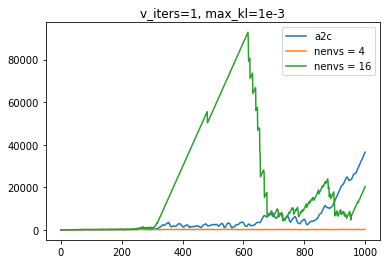

In [12]:
plt.title('v_iters=1, max_kl=1e-3')
plt.plot(prog_a2c['ma_ep_ret'], label='a2c')
plt.plot(prog_3['ma_ep_ret'], label='nenvs = 4')
plt.plot(prog_4['ma_ep_ret'], label='nenvs = 16')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.show()

Observation:
- TRPO can find good policy a lot faster, but it is not as stable as A2C
- Number of envs (i.e. number of experiences) makes a huge difference for TRPO

## Use a smaller architecture and more iterations in conjugate gradient

```python
nenvs = 16
env = ParallelEnvBatch(make_env, nenvs=nenvs)

TRPO(
    env=env,
    nsteps=32, 
    total_timesteps=nenvs*32*10000,
    gamma=0.99,
    log_interval=10,
    reward_transform=None,
    log_dir='/home/ubuntu/reinforcement-learning/experiments/TRPO/8',
    ckpt_dir='/home/ubuntu/reinforcement-learning/experiments/TRPO/8',
    max_kl=1e-3,
    cg_iters=20,
    cg_damping=1e-2,
    backtrack_steps=10,
    v_iters=1,
    batch_size=nenvs*32,
    v_lr=1e-4,
    hidden_layers=[32, 32, 32],
    activation=torch.nn.ReLU
)
```


In [14]:
prog_8 = pd.read_csv(
    '/home/ubuntu/reinforcement-learning/experiments/TRPO/8/progress.csv'
)

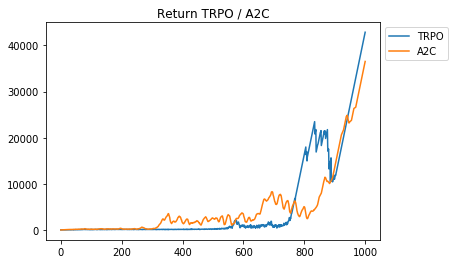

In [15]:
plt.title('Return TRPO / A2C')
plt.plot(prog_8['ma_ep_ret'], label='TRPO')
plt.plot(prog_a2c['ma_ep_ret'], label='A2C')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.show()

Observation:
- TRPO tends to have sharp policy boost

## On continuous problem

Pendulum-v0 is an easy test bed for problems with continuous action space
https://www.youtube.com/watch?v=DSU1KKeAe00

The smaller the angle between the pendulum and the upwards direction, the higher the reward. 

A2C spec

Truncate the env after 200 steps
Look at the mean step reward in each iteration

```python
def pendulum():
    """Make env for pendulum"""

    env = gym.make('Pendulum-v0')
    #env = TransformReward(env, normalize_pendulum)
    #env = Truncate(env, lower_bound=-10)
    env = AutoReset(env)
    return env

nenvs = 16
env=ParallelEnvBatch(pendulum, nenvs=nenvs)

A2C(
    env=env,
    nsteps=32,
    gamma=0.99,
    total_timesteps=32*nenvs*10000,
    pi_lr=1e-4,
    v_lr=1e-4,
    ent_coef=0.0,
    log_interval=10,
    max_grad_norm=0.1,
    reward_transform=None,
    log_dir= '/home/ubuntu/reinforcement-learning/experiments/A2C_2/log/pendulum/4',
    ckpt_dir='/home/ubuntu/reinforcement-learning/experiments/A2C_2/log/pendulum/4',
    hidden_layers=[64, 64, 16],
    activation=torch.nn.ReLU
)
```

----

TRPO spec

```python
nenvs = 8
env = ParallelEnvBatch(pendulum, nenvs=nenvs)

TRPO(
    env=env,
    nsteps=128, 
    total_timesteps=nenvs*128*10000,
    gamma=0.99,
    log_interval=10,
    reward_transform=None,
    log_dir='/home/ubuntu/reinforcement-learning/experiments/TRPO/pendulum/3',
    ckpt_dir='/home/ubuntu/reinforcement-learning/experiments/TRPO/pendulum/3',
    max_kl=1e-2,
    ent_coef=0.0,
    cg_iters=10,
    cg_damping=1e-2,
    backtrack_steps=10,
    v_iters=1,
    batch_size=nenvs*32,
    v_lr=1e-4,
    hidden_layers=[256, 256, 64],
    activation=torch.nn.ReLU
)
```

The model used in TRPO is much bigger. 




In [15]:
prog_pen_a2c = pd.read_csv(
'/home/ubuntu/reinforcement-learning/experiments/A2C_2/log/pendulum/4/progress.csv'
)
prog_pen_3 = pd.read_csv(
'/home/ubuntu/reinforcement-learning/experiments/TRPO/pendulum/3/progress.csv'
)

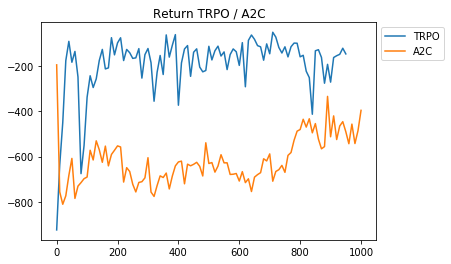

In [17]:
plt.title('Return TRPO / A2C')
plt.plot(prog_pen_3['ma_ep_ret'][::10], label='TRPO')
plt.plot(prog_pen_a2c['ma_ep_ret'][::10], label='A2C')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.show()

In [25]:
prog_pen_3.columns

Index(['FPS', 'Q', 'VQDiff', 'entropy', 'ma_ep_len', 'ma_ep_ret',
       'mean_rew_step', 'meankl', 'policy_net_weight', 'step_size',
       'surr_gain', 'value_loss', 'value_net_weight', 'vpreds'],
      dtype='object')

In [28]:
prog_a2c.columns

Index(['FPS', 'Q', 'entropy', 'explained_variance', 'frac',
       'iteration/nupdates', 'ma_ep_len', 'ma_ep_ret', 'mean_rew_step',
       'policy_loss', 'policy_net_weight', 'step_size', 'value_loss',
       'value_net_weight', 'vpreds', 'vqdiff'],
      dtype='object')

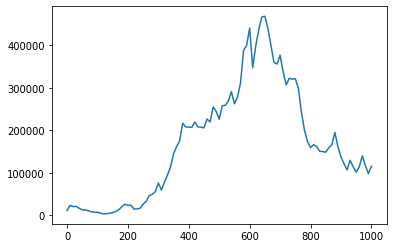

In [31]:
plt.plot(prog_a2c['vqdiff'][::10])

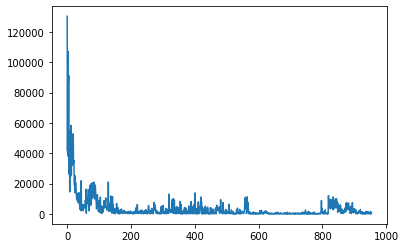

In [32]:
plt.plot(prog_pen_3['VQDiff'])

## Algorithms in action

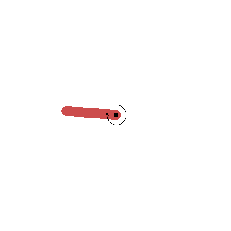

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import gym
import rlkits
from rlkits.policies import PolicyWithValue
import torch

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    return


#env = gym.make('CartPole-v0').unwrapped
env = gym.make('Pendulum-v0').unwrapped
ob_space = env.observation_space
ac_space = env.action_space

pi = PolicyWithValue(
    ob_space=ob_space,
    ac_space=ac_space,
    ckpt_dir='/tmp',
    #hidden_layers=[32, 32, 32],
    #hidden_layers=[256, 512],
    #hidden_layers=[256, 256, 64], # (3, 256, 256, 64, 2)
    
    hidden_layers=[64, 64, 16],
    activation=torch.nn.ReLU
)

pi.load_ckpt(
    # cartpole
    #'/home/ubuntu/reinforcement-learning/experiments/TRPO/4/ckpt.pth'
    #'/home/ubuntu/reinforcement-learning/experiments/TRPO/8/ckpt-best.pth'
    #'/home/ubuntu/reinforcement-learning/experiments/A2C_2/debug/12/ckpt.pth'
    
    # pendulum
    #'/home/ubuntu/reinforcement-learning/experiments/TRPO/pendulum/3/ckpt-best.pth'
    '/home/ubuntu/reinforcement-learning/experiments/A2C_2/log/pendulum/4/ckpt-best.pth'
)

observation = env.reset()
for t in range(1500):
    action, _, _ = pi.step(observation)
    show_state(env, t)
    observation, reward, done, info = env.step(action[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        plt.clf()
        break
plt.clf()